In [0]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np

from itertools import chain

import string

from keras.datasets import imdb

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score 

import pickle

## Import des données


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
my_path = "drive/My Drive/amazon/"

On extrait les tableaux X_train, y_train, X_test, y_test du dataset Amazon reviews.

In [0]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

X_train est composé de 25 000 listes de nombres. \\
Par exemple, le nombre 3 correspond au 3ème mot le plus fréquent dans le corpus.

On crée une fonction decode_review qui transforme les nombres dans X_train en mots.

In [0]:
# Un dictionnaire mappant des mots sur un index entier

word_index = imdb.get_word_index()

# Les premiers index sont réservés
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # inconnu
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text if i !=1])


Par exemple, ci-dessous on a décodé le premier commentaire.

In [0]:
(decode_review(X_train[0]))

"this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be 

On représente le nombre de revues dont le label est 0 et le nombre de revues avec un label qui vaut 1 dans l'échantion d'entraînement (0 correspond aux commentaires négatifs et 1 correspond aux commentaires positifs). \\


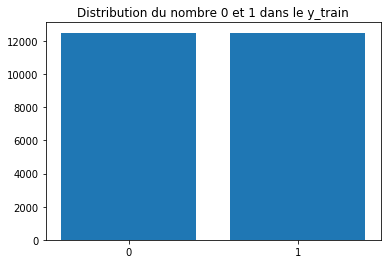

In [0]:
zero = list(y_train).count(0)
one = list(y_train).count(1)

label = ['0','1']
height = [zero, one]
y_pos = np.arange(len(label))
plt.bar(y_pos, height)
plt.xticks(y_pos, label)
plt.title('Distribution du nombre 0 et 1 dans le y_train')
plt.show()

In [0]:
print("Le nombre de 0 dans le y_train est de :", zero)
print("Le nombre de 1 dans le y_train est de :", one)

Le nombre de 0 dans le y_train est de : 12500
Le nombre de 1 dans le y_train est de : 12500


On remarque qu'il y a autant de 0 que de 1 dans le y_train. \\


## Une partie des données

On prend tout d'abord les 30 premières revues du dataset.

In [0]:
X_sub = [decode_review(X_train[i]) for i in range(30)]

y_sub = y_train[0:30]

data_sub = {'revue': X_sub, 'label':y_sub}

In [0]:
import pandas as pd

In [0]:
df_sub = pd.DataFrame(data_sub)
df_sub.head()

,revue,label
0,this film was just brilliant casting location ...,1
1,big hair big boobs bad music and a giant safet...,0
2,this has to be one of the worst films of the 1...,0
3,the scots excel at storytelling the traditiona...,1
4,worst mistake of my life br br i picked this m...,0


A présent, on cherche à représenter les mots les plus fréquents dans ces 30 commentaires. \\
On crée alors la fonction most_frequent_words.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
def most_frequent_words(data):
    """
    affiche l'histogramme des mots les plus fréquents d'une liste de chaine de caractères 
    affiche la taille du dictionnaire
    retourne le dictionnaire
    :param data: liste de chaine de caractère
    :return: le dictionnaire de data
    """ 
   
    count_vect = CountVectorizer()
    data_counts = count_vect.fit_transform(data)
    dictionary   = count_vect.get_feature_names()
    print("Taille du dictionnaire : ",len(dictionary))
    
    word_counts = pd.DataFrame(data_counts.toarray(),columns = dictionary)
    word_total_counts = pd.DataFrame()
    word_total_counts['count'] = word_counts.sum(axis=0)
    word_total_counts['word'] = dictionary
    word_total_counts_sorted_top  = word_total_counts.sort_values(by="count",ascending = False).iloc[0:20]
    
    plt.figure(figsize=(15,8))
    sns.barplot(x = word_total_counts_sorted_top.index,y=word_total_counts_sorted_top['count'])
    plt.xticks(rotation=90,fontsize=10)
    plt.show()
    return dictionary

On applique cette fonction à X_sub.

Taille du dictionnaire :  2058


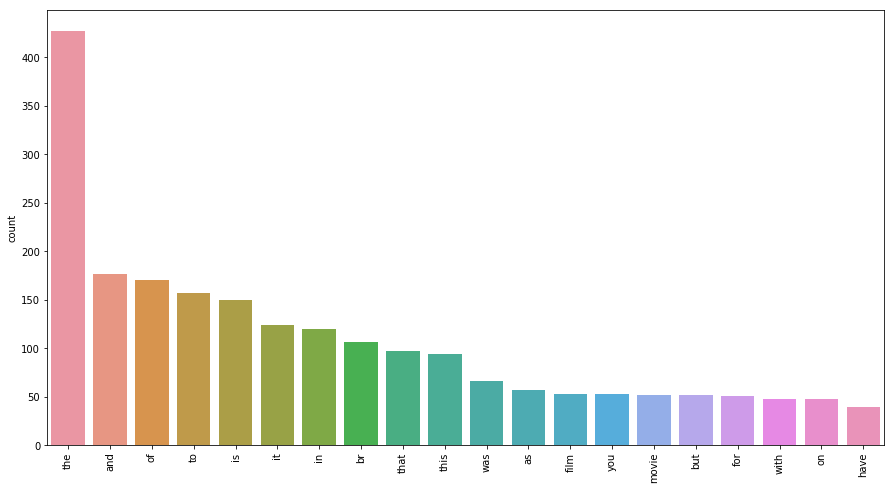

In [0]:
dico = most_frequent_words(df_sub['revue'])

On remarque que les mots les plus fréquents ne sont pas importants. Ils ne nous permettent pas de déterminer si le commentaire est positif ou négatif.\\

In [0]:
print(dico)

['000', '10', '12', '15', '18th', '19', '1938', '1940', '1975', '1981', '1984', '1990s', '1995', '1998', '2006', '2007', '2008', '25', '40', '40s', '50', '70', '80', '80s', '85', '86', '90s', 'able', 'abomination', 'about', 'above', 'abraham', 'abusive', 'accent', 'accented', 'acceptable', 'accepted', 'accessability', 'accused', 'across', 'act', 'acting', 'actor', 'actors', 'actual', 'actually', 'ada', 'adaption', 'add', 'added', 'addict', 'addicted', 'addition', 'address', 'advani', 'advantage', 'affections', 'after', 'afterwards', 'again', 'against', 'age', 'aged', 'ageing', 'agent', 'agree', 'aimed', 'ain', 'airphone', 'akin', 'akshaye', 'album', 'alec', 'alert', 'alive', 'all', 'almost', 'along', 'also', 'altieri', 'always', 'am', 'amazement', 'amazing', 'ambition', 'american', 'among', 'amores', 'amount', 'amusing', 'an', 'ancient', 'and', 'andrew', 'angles', 'angus', 'anil', 'annoyed', 'annoying', 'another', 'answer', 'antoine', 'any', 'anyone', 'anything', 'aonghas', 'appear', '

On remarque également, la présence de nombres dans le dictionnaire qui ne nous intéressent pas pour notre étude. \\
Il faut alors "nettoyer les données" avant de pouvoir appliquer les algorithmes de machine learning.

##Le data set entier

On considère maintenant tout le data set. \\


On considère que le but de la classification des commentaires en commentaires positifs et négatifs, est de pouvoir classer un nouveau commentaire : s'il est positif ou négatif. De la même manière que de classer des spams.

On doit alors : \\
- supprimer la ponctuation
- "lemmatizer" les mots : par exemple, les mots "is", "are", "were" doivent être transformer en "be" en utilisant WordNetLemmatizer() 
- supprimer les stop words et les mots fréquents qui ne nous renseignent pas sur le caractère positif ou négatif du commentaire. Dans notre cas : on peut supprimer les mots : movie, film, br, one, story ...

In [0]:
import re
import unicodedata

#Natural language processing tool-kit
import nltk    
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('all')
from nltk.corpus import stopwords #Stopwords corpus
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

On définit une fonction clean qui prend comme paramètre une liste du même type que X_train (liste de liste de nombres), et qui retourne une liste de phrases 'nettoyées'.

In [0]:
def get_wordnet_pos(word):
    """Récupère le type de word via nltk et retourne une valeur acceptée par lemmatize() 
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
  

lemmatizer = WordNetLemmatizer() 

def clean(X):
  """
  retourne corpus_clean
  param : X : array contenant des listes de nombres
  return : corpus_clean
  """     
  corpus=[decode_review(text) for text in X]
  
  #supprime toute la ponctuation
  translator = str.maketrans('','', string.punctuation)
  corpus = [(text).translate(translator) for text in corpus] 
  
  corpus_med = []
  for sentence in corpus:
    # supprime tous les caractères spéciaux
    processed_feature = re.sub(r'\W', ' ', str(sentence))
    
    #supprime tous les accents
    processed_feature = unicodedata.normalize('NFKD', processed_feature)
    processed_feature = processed_feature.encode('ASCII', 'ignore') 
    processed_feature = processed_feature.decode("utf-8") 
    
    # Supprime tous les nombres
    processed_feature = re.sub(r"\d", "", processed_feature)
    
    # Supprime les caractères seuls
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    #Supprime les caractères seuls du début
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Remplace les espaces multiples par un seul espace
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    
    corpus_med.append(processed_feature)
    
  #création d'un vocabulaire afin d'utiliser lemmatizer une seule fois par mot
  vocabulaire = set()
  for text in corpus_med:
    for word in text.split():
      vocabulaire.add(word) 
  vocabulaire = list(vocabulaire)   
  translation_map = {}
  for w in set(vocabulaire):
    translation_map[w] = lemmatizer.lemmatize(w, get_wordnet_pos(w))
    
  #corpus "lemmatisé"
  text_clean = [[translation_map[w] for w in text.split()] for text in corpus_med] 
  
  corpus_clean = [' '.join(ligne) for ligne in text_clean]
  
  return corpus_clean
  
  

On teste cette fonction pour le premier commentaire.

In [0]:
com = [decode_review(X_train[0])]
com

["this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be

In [0]:
com_clean = clean(X_train[0:1])
com_clean

['this film be just brilliant cast location scenery story direction everyones really suit the part they played and you could just imagine be there robert redford be an amaze actor and now the same be director norman father come from the same scottish island a myself so love the fact there be real connection with this film the witty remark throughout the film be great it be just brilliant so much that bought the film a soon a it be release for retail and would recommend it to everyone to watch and the fly fishing be amaze really cry at the end it be so sad and you know what they say if you cry at film it must have be good and this definitely be also congratulation to the two little boy that played the part of norman and paul they be just brilliant child be often left out of the praise list think because the star that play them all grown up be such big profile for the whole film but these child be amaze and should be praise for what they have do dont you think the whole story be so lovel

In [0]:
#on transforme com et com_clean en liste de mots
tab_clean = []
tab = []

for i in com_clean:
  for k in i.split():
    tab_clean.append(k)

for j in com:
  for l in j.split():
    tab.append(l)

#on récupère les mots différents entre les deux listes tab et tab_clean
res1 = []
res2 = []

for i in range(len(tab_clean)):
  if tab_clean[i]!=tab[i]:
    res1.append(tab_clean[i])
    res2.append(tab[i])
    



In [0]:
lem = {'com': res2, 'com_clean':res1}
df_clean = pd.DataFrame(lem)
df_clean.head()

,com,com_clean
0,was,be
1,casting,cast
2,everyone's,everyones
3,suited,suit
4,being,be


On remarque que notre fonction clean à l'air de bien fonctionner.

On applique cette fonction à X_train.

In [0]:
corpus_final = clean(X_train)

In [0]:
data = {'revue': corpus_final, 'label':y_train}
df = pd.DataFrame(data)
df.head()

,revue,label
0,this film be just brilliant cast location scen...,1
1,big hair big boob bad music and giant safety p...,0
2,this have to be one of the bad film of the whe...,0
3,the scot excel at storytelling the traditional...,1
4,bad mistake of my life br br picked this movie...,0


Notre jeu de données contient toujours des mots tels que : the, of, this... \\
Ce sont des stop words qu'il faudra supprimer.

Stop contient les stop words ainsi que les mots que l'on souhaite supprimer du jeu de données.

In [0]:
stop = set(stopwords.words('english'))
stop.update({'br','story','film','movie','movies','one','make','see'})
print(stop)


{'hasn', 'before', 'can', 'you', 'about', 'with', 'same', "you've", "aren't", 'while', 'which', 'will', 'too', 'do', 'at', 'they', "mustn't", 'have', 'yourselves', 'don', 't', 'see', 'them', 'we', 'were', 'does', 'in', 'here', 'down', 'on', 'isn', 'nor', 'if', 'further', 'll', 'movies', "she's", 'very', 'only', 'ours', 'itself', 'no', 'than', "doesn't", 'into', 'after', 'ma', 'be', 'against', 'did', 'up', 'any', 'under', 'film', 'our', 'now', 'shouldn', "wasn't", 'what', 'those', 'for', 'hadn', "it's", 'as', 'doesn', 'your', 'won', 'm', 'wasn', 'i', 'movie', 'there', 'its', 'by', 'doing', 'other', 'between', "shouldn't", 'herself', "you're", 'few', 'the', "won't", "wouldn't", 'how', 'him', "should've", 'had', 'wouldn', 'above', 'd', 'until', 'mightn', 'he', 'needn', 'off', 'so', 'to', 'whom', 'that', 'through', "weren't", "you'd", 'both', 'y', 'yourself', 'my', 'just', 'it', 'own', "didn't", 'such', 'a', 'themselves', 'is', "couldn't", 'an', 'having', 'am', 'me', 'being', 're', 'hers',

# Avec les counts

On applique l'objet CountVectorizer qui convertit une collection de documents texte en une matrice creuse.

In [0]:
count_vect = CountVectorizer(stop_words=stop)

X_train = count_vect.fit_transform(df['revue'])
liste_de_mots = count_vect.get_feature_names()
dictionary = set(liste_de_mots)


corpus_test contient tous les commentaires du X_test après avoir supprimer les mots non présents dans dictionary.  

In [0]:
corpus_test = [' '.join(word for word in line.split() if word in dictionary) for line in clean(X_test)]

On transforme ce corpus_test en matrice creuse X_test

In [0]:
count_vect = CountVectorizer(stop_words=stop,vocabulary=liste_de_mots)
X_test = count_vect.fit_transform(corpus_test)
assert liste_de_mots == count_vect.get_feature_names() 


On vérifie que la taille du dictionnaire est la même pour X_train et X_test.



In [0]:
print(X_train.shape, X_test.shape)

(25000, 62455) (25000, 62455)


On utilise plusieurs algorithmes de classification pour pouvoir comparer leurs accuracy.

In [0]:
algorithms = []
acc = []

## Régression logistique

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

On fait une régression logistique qui utilise une régression Lasso (penalty='l1') de paramètre C.

On utilise GridSearchCV pour faire une cross validation en 5-fold pour déterminer le paramètre C qui maximise l'accuracy sur le test.

In [0]:
hyper_parameters = [{'C': np.linspace(0.001, 0.75, 5)}] 
params = dict(penalty='l1')

clf = GridSearchCV(LogisticRegression(**params), hyper_parameters, cv=5, scoring='accuracy')

In [0]:
clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': array([0.001  , 0.18825, 0.3755 , 0.56275, 0.75   ])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
pd.DataFrame(clf.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.415162,0.037753,0.003823,0.000170,0.001,{'C': 0.001},0.6464,0.6596,0.6506,0.6518,0.6446,0.65060,0.005217,5
1,0.558010,0.034214,0.003508,0.000098,0.18825,{'C': 0.18825},0.8754,0.8746,0.8702,0.8726,0.8704,0.87264,0.002118,2
2,0.640119,0.025065,0.003532,0.000119,0.3755,{'C': 0.3755},0.8718,0.8754,0.8732,0.8744,0.8760,0.87416,0.001515,1
3,0.719588,0.011329,0.003480,0.000100,0.56275,{'C': 0.56275},0.8674,0.8732,0.8714,0.8690,0.8732,0.87084,0.002310,3
4,0.801881,0.006711,0.003495,0.000103,0.75,{'C': 0.75},0.8624,0.8730,0.8724,0.8682,0.8694,0.86908,0.003792,4


On trouve que le meilleur paramètre est C = 0.3755.
On entraîne alors ce modèle avec X_train, y_train et on prédit ensuite les labels de X_test.

In [0]:
logreg = LogisticRegression(**params, **clf.best_params_)

logreg.fit(X_train,y_train)

LogisticRegression(C=0.3755, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = logreg.predict(X_test)
acc_logi = accuracy_score(logreg.predict(X_test),y_test)

algorithms.append('logreg')
acc.append(acc_logi)

print('Accuracy sur le test: {:.2f}'.format(acc_logi))

Accuracy sur le test: 0.87


On affiche la matrice de confusion pour ce modèle.

In [0]:
confusion_matrix(y_pred,y_test)

array([[10898,  1663],
       [ 1602, 10837]])

On observe que :
 - il y a 10898 commentaires de X_test pour lesquels : y_test = y_pred = 0 (true positives)
 - 1661 commentaires de X_test pour lesquels : y_test =1 != y_pred = 0 (false positives)
 - 1602 commentaires de X_test pour lesquels : y_test =0 != y_pred = 1 (false negatives)
 - 10839 commentaires de X_test pour lesquels : y_test = y_pred = 1 (true negatives)

Ce modèle ne s'est pas trompé dans la majorité des cas.

In [0]:
import sklearn.metrics as metrics

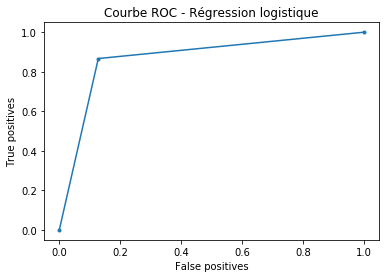

In [0]:
fpr1, tpr1, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr1, tpr1)

plt.plot(fpr1, tpr1, marker='.')
plt.title("Courbe ROC - Régression logistique")
plt.xlabel("False positives")
plt.ylabel("True positives")
plt.show()



## KNN

In [0]:
from sklearn.neighbors import KNeighborsClassifier

On cherche un k qui maximise l'accuracy sur le test.

Text(0.5, 1.0, 'Accuracy sur le test en fonction de k')

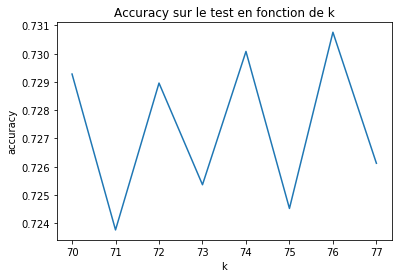

In [0]:
result = []
n_values = range(70,78)
for n in n_values:
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train, y_train)
    Z = clf.predict(X_test)
    score = accuracy_score(Z, y_test)
    result.append(score)

plt.plot(list(n_values), result)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("Accuracy sur le test en fonction de k")


Graphiquement, on trouve que pour k = 76 l'accuracy est la plus grande.

In [0]:

classifier = KNeighborsClassifier(n_neighbors=76)
classifier.fit(X_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=76, p=2,
                     weights='uniform')

In [0]:
y_pred = classifier.predict(X_test)
acc_knn = accuracy_score(y_pred,y_test)

algorithms.append('knn')
acc.append(acc_knn)

print('Accuracy sur le test: {:.2f}'.format(acc_knn))

Accuracy sur le test: 0.73


On affiche la matrice de confusion pour ce modèle.

In [0]:
confusion_matrix(y_pred,y_test)

array([[ 7376,  1607],
       [ 5124, 10893]])

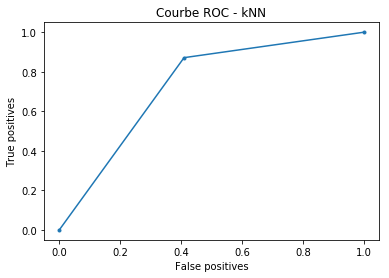

In [0]:
fpr2, tpr2, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, marker='.')
plt.title("Courbe ROC - kNN")
plt.xlabel("False positives")
plt.ylabel("True positives")
plt.show()

## Arbres de décision

In [0]:
from sklearn.tree import DecisionTreeClassifier

On cherche à déterminer la profondeur de l'arbre qui maximise l'accuracy du test.

In [0]:
parameters = {'max_depth':range(13,18)}
clf = GridSearchCV(DecisionTreeClassifier(), parameters)
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_


In [0]:
from sklearn import tree
tree = tree.DecisionTreeClassifier(**clf.best_params_)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=16,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

On a trouvé comme profondeur de l'arbre 16.

In [0]:
y_pred = tree.predict(X_test)
acc_tree = accuracy_score(y_pred,y_test)

algorithms.append('tree')
acc.append(acc_tree)

print('Accuracy sur le test: {:.2f}'.format(acc_tree))

Accuracy sur le test: 0.75


On affiche la matrice de confusion pour ce modèle.

In [0]:
confusion_matrix(y_pred,y_test)

array([[ 8299,  2133],
       [ 4201, 10367]])

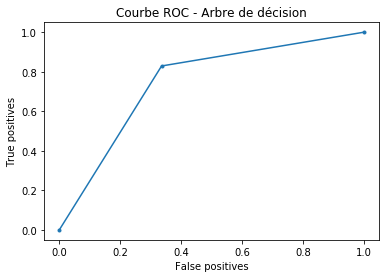

In [0]:
fpr3, tpr3, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr3, tpr3)

plt.plot(fpr3, tpr3, marker='.')
plt.title("Courbe ROC - Arbre de décision")
plt.xlabel("False positives")
plt.ylabel("True positives")
plt.show()

## Naive Bayes

In [0]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [0]:
NB_counts = MultinomialNB()
NB_counts.fit(X=X_train,y=y_train)
y_pred = NB_counts.predict(X_test)
acc_nbcounts = accuracy_score(y_pred,y_test)

algorithms.append('naive bayes')
acc.append(acc_nbcounts)

print('Accuracy sur le test: {:.2f}'.format(acc_nbcounts))

Accuracy sur le test: 0.82


On affiche la matrice de confusion pour ce modèle.

In [0]:
confusion_matrix(y_pred,y_test)

array([[10990,  2913],
       [ 1510,  9587]])

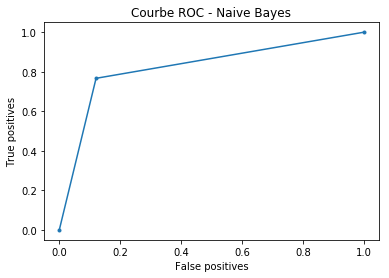

In [0]:
fpr4, tpr4, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr4, tpr4)

plt.plot(fpr4, tpr4, marker='.')

plt.title("Courbe ROC - Naive Bayes")
plt.xlabel("False positives")
plt.ylabel("True positives")
plt.show()

## Graphe count

On observe que l'algorithme produisant la meilleure accuracy sur le test est la régression logistique.

Text(0, 0.5, 'accuracy')

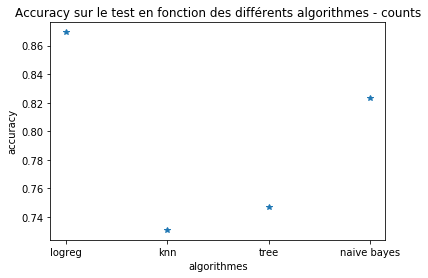

In [0]:
plt.plot(algorithms,acc,'*')
plt.title("Accuracy sur le test en fonction des différents algorithmes - counts")
plt.xlabel("algorithmes")
plt.ylabel("accuracy")

Courbes ROC

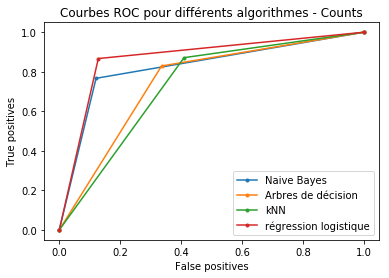

In [0]:
plt.plot(fpr4, tpr4, marker='.',label = 'Naive Bayes')
plt.plot(fpr3, tpr3, marker='.',label='Arbres de décision')
plt.plot(fpr2, tpr2, marker='.', label='kNN')
plt.plot(fpr1, tpr1, marker='.',label = 'régression logistique')
plt.title("Courbes ROC pour différents algorithmes - Counts")
plt.xlabel("False positives")
plt.ylabel("True positives")
plt.legend(loc="lower right")
plt.show()

On observe que le meilleur algorithme est la régression logistique pour les counts.

# TF-IDF

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

TF_IDF est une méthode de pondération qui permet d'évaluer l'importance d'un mot contenu dans un commentaire relativement à un corpus.

In [0]:
vectorizer = TfidfVectorizer(stop_words=stop,max_features=10000)
X_traintf = vectorizer.fit_transform(corpus_final).toarray()
dico = vectorizer.get_feature_names()
dictionary = set(dico)

On a limité la taille du dictionnaire à 10 000 mots car sinon le programme plante.


corpus_test contient tous les commentaires du X_test après avoir supprimer les mots non présents dans dictionary.  

In [0]:
corpus_test = [' '.join(word for word in line.split() if word in dictionary) for line in clean(X_test)]

In [0]:
vecttf = TfidfVectorizer(stop_words=stop,vocabulary=dico,max_features=10000)
X_testtf = vecttf.fit_transform(corpus_test).toarray()
assert dico == vecttf.get_feature_names() 


## Naive Bayes

In [0]:
NB_tfidf = GaussianNB()
NB_tfidf.fit(X=X_traintf,y=y_train)
y_pred = NB_tfidf.predict(X_testtf)
acc_nbtfidf=accuracy_score(y_pred,y_test)

In [0]:
print('Accuracy sur le test: {:.2f}'.format(acc_nbtfidf))

Accuracy sur le test: 0.69


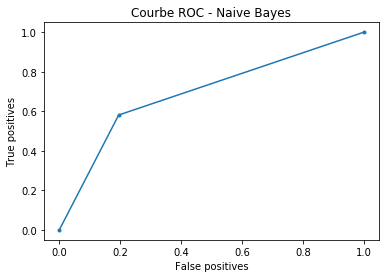

In [0]:
fpr5, tpr5, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr5, tpr5)

plt.plot(fpr5, tpr5, marker='.')

plt.title("Courbe ROC - Naive Bayes")
plt.xlabel("False positives")
plt.ylabel("True positives")
plt.show()

On affiche la matrice de confusion pour ce modèle.

In [0]:
confusion_matrix(y_pred,y_test)

array([[10061,  5234],
       [ 2439,  7266]])

##LDA

In [0]:
lda = LinearDiscriminantAnalysis()
lda.fit(X=X_traintf,y=y_train)
y_pred = lda.predict(X_testtf)
acc_lda=accuracy_score(y_pred,y_test)

In [0]:
print('Accuracy sur le test: {:.2f}'.format(acc_lda))

Accuracy sur le test: 0.79


On affiche la matrice de confusion pour ce modèle.

In [0]:
confusion_matrix(y_pred,y_test)

array([[10096,  2807],
       [ 2404,  9693]])

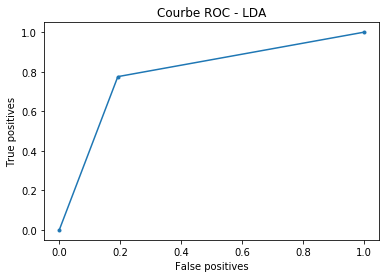

In [0]:
fpr6, tpr6, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr6, tpr6)

plt.plot(fpr6, tpr6, marker='.')

plt.title("Courbe ROC - LDA")
plt.xlabel("False positives")
plt.ylabel("True positives")
plt.show()

## QDA

In [0]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X=X_traintf,y=y_train)
y_pred = qda.predict(X_testtf)
acc_qda=accuracy_score(y_pred,y_test)

In [0]:
print('Accuracy sur le test: {:.2f}'.format(acc_qda))

Accuracy sur le test: 0.70


On affiche la matrice de confusion pour ce modèle.

In [0]:
confusion_matrix(y_pred,y_test)

array([[9451, 4551],
       [3049, 7949]])

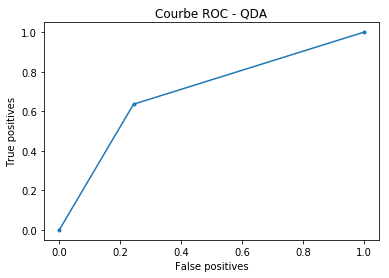

In [0]:
fpr7, tpr7, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr7, tpr7)

plt.plot(fpr7, tpr7, marker='.')

plt.title("Courbe ROC - QDA")
plt.xlabel("False positives")
plt.ylabel("True positives")
plt.show()

## Graphes tfidf

In [0]:
algo=["Naive Bayes","LDA","QDA"]
accu=[acc_nbtfidf,acc_lda,acc_qda]

Text(0, 0.5, 'accuracy')

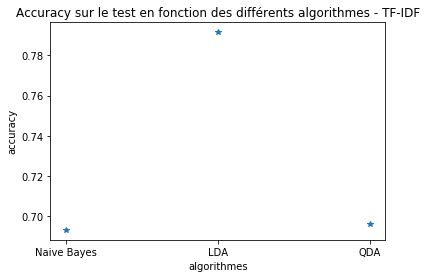

In [0]:
plt.plot(algo,accu,'*')
plt.title("Accuracy sur le test en fonction des différents algorithmes - TF-IDF")
plt.xlabel("algorithmes")
plt.ylabel("accuracy")

Courbes ROC

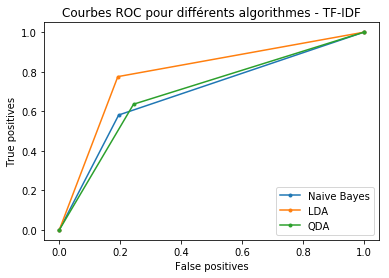

In [0]:
plt.plot(fpr5, tpr5, marker='.',label='Naive Bayes')
plt.plot(fpr6, tpr6, marker='.',label='LDA')
plt.plot(fpr7, tpr7, marker='.',label='QDA')
plt.title("Courbes ROC pour différents algorithmes - TF-IDF")
plt.xlabel("False positives")
plt.ylabel("True positives")
plt.legend(loc="lower right")
plt.show()

On remarque que le meilleur algorithme avec TF-IDF est le LDA.

#Conclusion 

En comparant les accuracy sur le test et les courbes Roc, on a remarqué que le meilleur algorithme est celui de la régression logistique avec les counts. \\
En revanche, avec le TF-IDF les algorithmes produisent des accuracy plus faible ce qui peut être expliquer par la limitation de la taille du dictionnaire.
